In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import json
import sqlite3
import networkx as nx
from itertools import cycle
import tqdm

from src.author_mapping.scripts.map_abbreviations_to_authors import map_abbreviations_to_authors

In [2]:
con = sqlite3.connect('../data/interim/articles_with_author_mapping.db')
cur = con.cursor()

In [3]:
authors, authors_frequency_score, authors_department_score, author_mapping, self_referencing_authors, remaining_abbrs = map_abbreviations_to_authors("../data/interim/articles_with_author_mapping.db")

Start mapping abbreviations to authors
Compute frequency score
Compute department score


100%|██████████| 275/275 [00:08<00:00, 33.48it/s]

Found 275 authors with both frequency and department score
Removed 3 self referencing nodes
constructed graph with 526 nodes and 454 edges
calculated new assigned graph with 391 nodes and 182 edges
author_mapping has 182 rows
after dummy removal: author_mapping has 135 rows
after adding self referencing authors: author_mapping has 138 rows
There are 27 abbreviations that were not matched
 The following abbreviations were not matched: ['ast', 'at', 'nie', 'mape', 'ttr', 'mot', 'mabe', 'beck', 'ms', 'thomas', 'th', 'haeg', 'ter vehn', 'döring', 'isc', 'grätz', 'sag', 'nag', 'roger', 'kreuz', 'dei', 'sie', 'iro', 'psz', 'cc', 'hem', 'almu']
21 abbreviations have only one edge in the old graph
add abbreviation ast to author Andreas Tappert
add abbreviation at to author Andreas Tappert
add abbreviation nie to author Nico Fliegner
add abbreviation mape to author Matthias Puppe
add abbreviation mot to author Matthias Roth
add abbreviation thomas to author Thomas Sparrer
add abbreviation th to

## Compute correlations for the complete matching

100%|██████████| 1/1 [00:30<00:00, 30.07s/it]


<Axes: xlabel='n_data_points', ylabel='pearson_coef'>

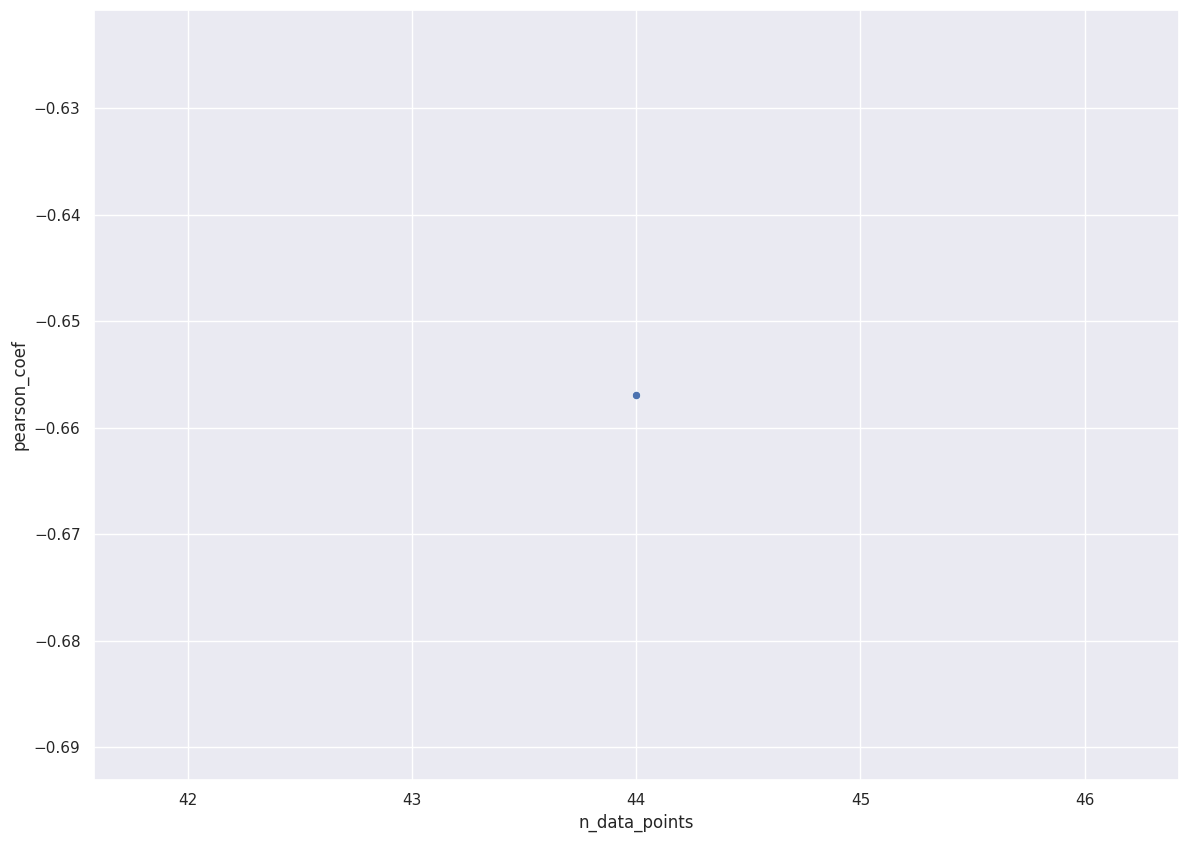

In [11]:
pearson_coef_sum = 0
pearson_p_value_sum = 0

correlation_df = pd.DataFrame(columns=["full_name", "abbreviation", "pearson_coef", "p_value", "n_data_points"])

# TODO: remove this, this is only for testing single names
#author_mapping = pd.DataFrame(columns=["full_name", "abbreviation"], data=[{"full_name": "Matthias Puppe", "abbreviation": "mpu"}])

for row in tqdm.tqdm([row for _, row in author_mapping.iterrows()]):
    abbr_authors = []
    abbr = row["abbreviation"]
    mapped_author = row["full_name"]
    author_like = f"%{json.dumps(mapped_author)}%"
    rows = cur.execute('select ar.published_at from articles ar where ar.author_array like ?', (author_like,)).fetchall()
    abbr_authors.extend([{"author": mapped_author, "type": "mapped name", "published_at": row[0]} for row in rows])

    
    abbr_like = f"%{json.dumps(abbr)}%"
    rows = cur.execute('select ar.published_at from articles ar where ar.author_array like ?', (abbr_like,)).fetchall()
    abbr_authors.extend([{"author": abbr, "type": "abbreviation", "published_at": row[0]} for row in rows])

    abbr_authors = pd.DataFrame(columns=["author", "type", "published_at"], data=abbr_authors)

    # aggregate by quarter of the year
    abbr_authors['published_at'] = pd.to_datetime(abbr_authors['published_at'])
    abbr_authors['quarter'] = abbr_authors['published_at'].dt.quarter
    abbr_authors['year'] = abbr_authors['published_at'].dt.year
    abbr_authors['year_quarter'] = abbr_authors['year'].astype(str) + "/" + abbr_authors['quarter'].astype(str)
    #abbr_authors['year_semester'] = abbr_authors['year'].astype(str) + "/" + abbr_authors['quarter'].apply(lambda x: 1 if x <= 2 else 2).astype(str)
    abbr_authors = abbr_authors.groupby(['year_quarter', 'author', 'type']).count()['published_at'].reset_index()
    # rename published at to count
    abbr_authors = abbr_authors.rename(columns={"published_at": "count"})
    
    # fill year_quarter gaps
    year_quarters = abbr_authors['year_quarter'].drop_duplicates()
    # get min and max year
    min_year = int(min(year_quarters).split("/")[0])
    max_year = int(max(year_quarters).split("/")[0])
    # get for min_year min quarter and for max_year max quarter
    min_quarter = int(min([year_quarter.split("/")[1] for year_quarter in year_quarters if year_quarter.split("/")[0] == str(min_year)]))
    max_quarter = int(max([year_quarter.split("/")[1] for year_quarter in year_quarters if year_quarter.split("/")[0] == str(max_year)]))
    # create all year_quarters
    year_quarters = [str(year) + "/" + str(quarter) for year in range(min_year, max_year + 1) for quarter in range(1, 5)]
        
    # for each author: if there is no entry for a unique combination of 'year_quarter', add it with count np.nan
    index = pd.MultiIndex.from_product([year_quarters, abbr_authors['author'].unique()], names=['year_quarter', 'author'])
    
    # Reindex the DataFrame with the MultiIndex to fill in missing combinations with NaN
    abbr_authors = abbr_authors.set_index(['year_quarter', 'author']).reindex(index, fill_value=None).reset_index()
    
    # set type for each author to first type of that author
    abbr_authors['type'] = abbr_authors.groupby('author')['type'].transform('first')
    
    # sort by year_quarter and type
    abbr_authors = abbr_authors.sort_values(by=['year_quarter', 'type'])
    
    # calculate pearson correlation coefficient
    # Extract relevant subsets from the DataFrame
    mapped_name_counts = abbr_authors[abbr_authors["type"] == "mapped name"][['year_quarter', 'count']]
    abbreviation_counts = abbr_authors[abbr_authors["type"] == "abbreviation"][['year_quarter', 'count']]
    
    # Merge the two DataFrames on the 'year_quarter' column
    merged_df = pd.merge(mapped_name_counts, abbreviation_counts, on='year_quarter', suffixes=('_mapped_name', '_abbreviation'))
    
    # Drop NaN values
    merged_df = merged_df.dropna()
    
    # Calculate Pearson correlation coefficient and p-value
    # test if df is long enough
    if merged_df.shape[0] < 2:
        print(f"not enough data points for author {mapped_author} and abbreviation {abbr}")
        continue
    correlation_coefficient, p_value = stats.pearsonr(merged_df['count_mapped_name'], merged_df['count_abbreviation'])
    # add to correlation_df
    correlation_df.loc[len(correlation_df)] = [mapped_author, abbr, correlation_coefficient, p_value, merged_df.shape[0]]
    
    
# scatterplot of pearson correlation coefficient for n_data_points
sns.scatterplot(data=correlation_df, x="n_data_points", y="pearson_coef")

In [9]:
# calculate average coef and p value
print(f"average pearson coefficient: {correlation_df['pearson_coef'].mean()}")
print(f"average p value: {correlation_df['p_value'].mean()}")

average pearson coefficient: -0.6569379228958092
average p value: 1.2772650352313683e-06


<Figure size 640x480 with 0 Axes>

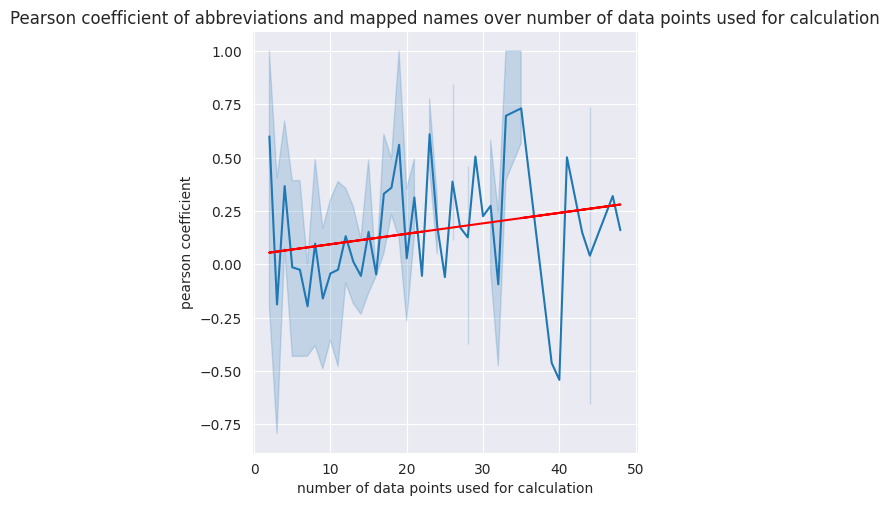

In [7]:
plt.cla()
plt.clf()

sns.relplot(kind='line', data=correlation_df, x="n_data_points", y="pearson_coef")
# run regression
slope, intercept, r_value, p_value, std_err = stats.linregress(correlation_df["n_data_points"], correlation_df["pearson_coef"])
# plot regression line
plt.plot(correlation_df["n_data_points"], intercept + slope*correlation_df["n_data_points"], 'r', label='fitted line')
# set y title to article count
plt.ylabel("pearson coefficient")
plt.xlabel("number of data points used for calculation")
sns.set(rc={'figure.figsize':(14,10)})
plt.tight_layout()
plt.title(f'Pearson coefficient of abbreviations and mapped names over number of data points used for calculation')
plt.savefig(f'../reports/figures/final_mapping_pearson_coefficient_of_abbreviations_and_mapped_names_over_number_of_data_points_used_for_calculation.png',bbox_inches='tight',dpi=300)
plt.show()
